<h1 style="text-align: center;">Supports pour le projet </h1>

Outre le fait de récupérer les données, ce notebook propose quelques conseils pour réussir le projet. Il précise, en autre, les classes et fonctions disponibles dans les guides que vous devez utiliser.

# Initialisation pour Colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import sys
my_local_drive='/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
sys.path.append(my_local_drive)

In [ ]:
# Check that the directory actually exists
import os
print(os.path.isdir(my_local_drive))

# Change directory
%cd "$my_local_drive"

False
[Errno 2] No such file or directory: '/content/gdrive/My Drive/Colab Notebooks/ML_FDS'
/content


Il est conseillé d'utiliser a minima ces librairies.

In [ ]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE

# Récupération du jeu de données

Le jeu de données a été créé à partir de données de la plateforme de partage de photos [Flickr](https://www.flickr.com). 4 catégories de 150 images et textes ont été créées :    
- bike
- ball
- water
- dog  

Chacune des catégories contient 150 images et textes associés.
La cellule suivante permet d'extraire le jeu de données qui sera organisé de la manière suivante :     

  flickr_subset2
├─ captions.csv  
├─ captions  
│  ├─ bike100.txt  
│  ├─ bike200.txt  
│  └─ ...   
└─ images  
   ├─ bike  
   │   ├─ bike150.png  
   │  ├─ bike151.png  
   │  └─ ...  
   ├─ ball  
   │  ├─ ball150.png  
   │  ├─ ball151.png  
   │  └─ ...  
   ├─ water  
   │  ├─ water150.png  
   │  ├─ water151.png  
   │  └─ ...  
   └─ dog  
      ├─ dog150.png  
      ├─ dog151.png  
      └─ ...  

 Le fichier `caption.csv`permet de faire la correspondance entre les images, les textes. Il contient le label de la classe (e.g. dog, water, ball, bike) et le texte associé à l'image.   


In [ ]:
url = "https://www.lirmm.fr/~poncelet/Ressources/flickr_subset2.zip"
target_dir = "flickr_subset2"

# Vérifie si le dossier existe déjà
if os.path.exists(target_dir) and os.path.isdir(target_dir):
    print("Données déjà disponibles dans :", target_dir)
else:
    print("Téléchargement de flickr_subset2.zip...")
    response = requests.get(url)
    if response.status_code == 200:
        print("Téléchargement réussi. Extraction...")
        with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
            # Extraire sans ajouter de sous-dossier supplémentaire
            for member in zip_ref.namelist():
                # Corrige les chemins pour ignorer un éventuel prefixe flickr_subset2/
                member_path = member
                if member.startswith("flickr_subset2/"):
                    member_path = member[len("flickr_subset2/"):]
                target_path = os.path.join(target_dir, member_path)

                # Si c'est un répertoire, on le crée
                if member.endswith("/"):
                    os.makedirs(target_path, exist_ok=True)
                else:
                    os.makedirs(os.path.dirname(target_path), exist_ok=True)
                    with zip_ref.open(member) as source, open(target_path, "wb") as target:
                        target.write(source.read())
        print(f"Données extraites dans : {target_dir}")
    else:
        print("Échec du téléchargement. Code HTTP :", response.status_code)


Données déjà disponibles dans : flickr_subset2


# Fonctions, classes et variables utiles pour la suite

[link text](https://)Les cellules suivantes contiennent des fonctions et des classes qui seront utiles pour votre projet. Les classes sont extraites des différents guides qui sont mis à votre disposition. Nous les recopions ici pour éviter de les chercher.   

**Attention :** il est important que vous compreniez bien le fonctionnement des classes, aussi n'hésitez pas à vous reporter à [Ressources Deep Learning](https://gite.lirmm.fr/poncelet/deeplearning) où vous de plus amples informations sur leur fonctionnement et leur usage.

In [ ]:
# FONCTIONS UTILES

def preview_images_from_dir(image_dir, image_size=(224, 224), n=12,
                            subset="training", seed=123):
    """
    Affiche n images avec leurs labels à partir d'un dossier
    (flow_from_directory).
    N'utilise PAS train_gen pour ne pas en avancer l'index.
    """
    # Générateur léger juste pour l'aperçu
    # Ici il y a une bonne indication si vous regardez bien pour la classif :)
    preview_datagen = ImageDataGenerator(validation_split=0.2, rescale=1./255)

    preview_gen = preview_datagen.flow_from_directory(
        image_dir,
        target_size=image_size,
        batch_size=n,
        class_mode="categorical",
        subset=subset,
        shuffle=True,
        seed=seed
    )

    imgs, y = next(preview_gen)    # imgs: (n, H, W, 3), y: one-hot
    class_names = list(preview_gen.class_indices.keys())
    labels = np.argmax(y, axis=1)

    rows = 3
    cols = int(np.ceil(n / rows))
    plt.figure(figsize=(4*cols, 4*rows))
    for i in range(min(n, imgs.shape[0])):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.tight_layout()
    plt.show()


Classes utiles pour la suite.

In [ ]:
# Classes à utiliser pour la partie classification de texte. Laquelle ?
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads,ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
            TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.1)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


Quelques variables qui peuvent être utiles pour le projet. Ces variables ont été définies pour l'apprentissage d'un modèle Clip réalisé avec les mêmes données. Elles devraient vous être utiles pour vos modèles. **Il est conseillé de conserver le nom des variables suivantes car nous vous donnerons un peu de code utilisant ces variables pour vous aider**.

In [ ]:
# Répertoire cible pour sauvegarder vos modèles
model_dir = "./models_forclip"
os.makedirs(model_dir, exist_ok=True)

# Répertoire des données
dataset_dir = "./flickr_subset2"

# Répertoire des images
image_dir = os.path.join(dataset_dir, "images")
# Répertoire des captions
captions_dir = os.path.join(dataset_dir, "captions")

# Variables utiles
# Attention respecter bien l'ordre alphabétique des classes pour
# le générateur
class_names = ['ball', 'bike', 'dog', 'water']
# Pour les images
image_size=(224, 224)
image_shape = image_size + (3,)

# Pour les textes
sequence_length = 32
vocab_size = 10000
num_heads = 4
ff_dim = 256
num_layers = 2

# Pour les images et les textes dans le modèle CLIP
embed_dim = 128

# Partie classification d'images

La cellule suivante affiche quelques images pour vous faire une idée de ce que vous manipulez.   

**Remarque :** n'hésitez pas à aller regarder comment les images sont obtenues pour les afficher ...

Found 480 images belonging to 4 classes.


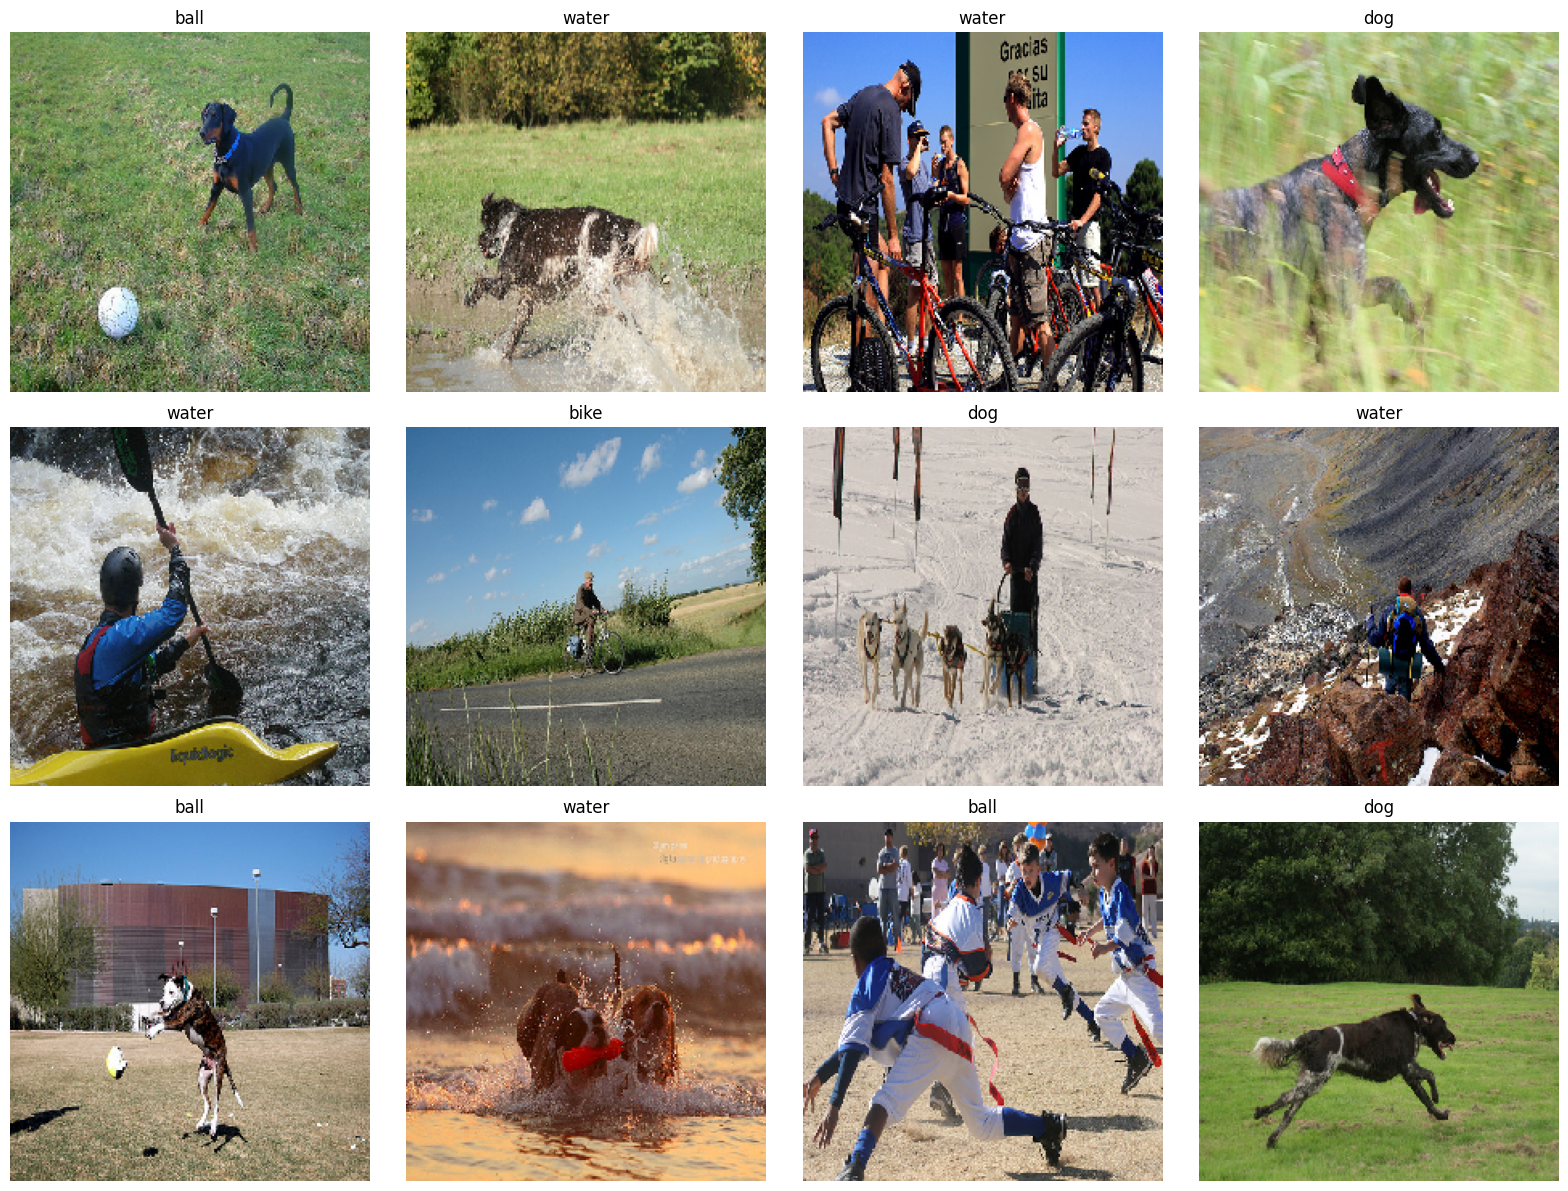

In [ ]:
# Affichage des images
preview_images_from_dir(image_dir, image_size=image_size, n=12, subset="training", seed=42)

**Remarques :**
- Les images sont en couleurs et ont une taille de 224x224. Cela veut dire qu'elles prennent beaucoup de place et qu'il n'est pas possible de les charger directement en mémoire pour l'apprentissage ou la validation. Il est donc indispensable de les envoyer à la volée, i.e. par batches. **Astuce :** Chercher dans les guides comment faire pour envoyer les images à la volée à partir d'un répertoire.
- L'entraînement du modèle peut être long aussi il est préférable de le sauvegarder au fur et à mesure. Pour cela dans la cellule ci-dessous vous trouverez une autre fonction callback : `ModelCheckpoint`. Elle sauvegarde à chaque epoch dans model_path (qui est initialisé en début de cellule) le modèle Keras avec les meilleurs poids. Vous verrez que la mesure suivie est la val_loss. Si elle s'améliore le modèle est sauvegardé. L'avantage est qu'en cas de problème vous aurez toujours une version sauvegardé.
- Pour votre loss, vous pourrez utiliser `loss="categorical_crossentropy`. Comme optimizer, utiliser `optimizer="adam`.    

**Conseil :** l'apprentissage d'un modèle peut être très long. Il est important avant de mettre un trop grand nombre d'epochs de vérifier que la sauvegarde de votre modèle est bien réalisée et que vous pouvez le recharger. Il n'y a rien de pire que d'attendre des heures et de se rendre compte qu'on a mal sauvegardé le modèle et qu'il faut tout recommencer !!! Normalement ici les fonctions (correspondant aux couches) utilisées sont "*built-in*", i.e. Keras les connait et ne posera pas de problèmes, il sait les sérialiser. Par contre dès que vous allez devoir définir des couches plus personnalisées il va falloir penser à mettre des *décorateurs* qui préciseront comment sérialiser le modèle pour le sauvegarder. Cela sera très utile pour la suite. Vous pouvez voir dans la partie classe utile pour la suite des exemples de décorateur (e.g `@tf.keras.utils.register_keras_serializable()`).  

# Partie classification de textes

**Remarques :**
- Les textes sont dans le dossier `captions` et dans `captions.csv` (avec les labels).
- Pour utiliser SmallBERT (ou BERT) n'oubliez pas qu'il est indispensable de "tokenizer" vos phrases. Vous pouvez par exemple utiliser `TextVectorization` de Keras (voir [TextVectorization](https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/)). Assurez-vous d'utiliser la même longueur `sequence_length` que celle attendue par SmallBERT. Regardez bien ce qu'il faut faire pour ajouter vos tokens au tokenizer.
- Comme vous allez apprendre le vocabulaire des mots qui sont dans `captions.csv` n'oubliez pas que par la suite vous en aurez besoin ... alors plutôt que de recommencer à chaque fois, pensez à le sauvegarder une fois pour toute. Pour accéder au vocabulaire appris, vous pouvez utiliser `.getvocabulary()` et simplement sauvegarder ce vocabulaire dans un fichier texte avec un mot par ligne comme par exemple `vocab.txt`.
- BERT et plus particulièrement SmallBERT n'est pas initialement fait pour faire de la classification. Il renvoie un tenseur séquence de forme `(batch, seq_len, embed_dim)`. Il va donc falloir le modifier un peu pour faire de la classification et donc lui ajouter un MLP comme classiquement. Ci-dessous quelques conseils pour vous aider à bien alimenter votre MLP.

Examinons un peu la sortie de SmallBERT. Considérons un batch composé des deux phrases suivantes :   
- *"a small red plane"*, après tokenization nous avons : Tokens (seq_len = 6) : [w1="a", w2="small", w3="red", w4="plane", PAD, PAD]"
- *"a big dog on the beach"*, après tokenization nous avons :
Tokens (seq_len = 6) : [w1="a", w2="big", w3="dog", w4="on", w5="the", w6="beach"]. Il n'y a pas de PAD car la séquence est pleine.   


A la sortie de SmallBERT nous avons un tenseur de la forme (batch=2, seq_len=6, embed_dim=3), i.e. sortie = (2, 6, 3). Pour simplifier nous prenons des embeddings de taille 3.   

Pour la première phrase (sortie[0, :, :]) la forme par phrase est (seq_len=6, embed_dim=3) donc 6 vecteurs de taille 3 :   
pos 0 ( "a" )      : [ 0.60, -0.20,  0.10 ]  
pos 1 ( "small" )  : [ 0.40,  0.30, -0.10 ]  
pos 2 ( "red" )    : [-0.20,  0.50,  0.20 ]  
pos 3 ( "plane" )  : [ 0.41, -0.12,  0.15 ]  
pos 4 ( PAD )      : [ 0.00,  0.00,  0.00 ]  
pos 5 ( PAD )      : [ 0.00,  0.00,  0.00 ]  

Pour la seconde phrase (sortie[1, :, :]) la forme par phrase est (seq_len=6, embed_dim=3) donc 6 vecteurs de taille 3 :  
pos 0 ( "a" )      : [ 0.20,  0.10, -0.30 ]  
pos 1 ( "big" )    : [ 0.00,  0.40,  0.20 ]  
pos 2 ( "dog" )    : [ 0.30, -0.20,  0.10 ]  
pos 3 ( "on" )     : [ 0.10,  0.00,  0.20 ]  
pos 4 ( "the" )    : [-0.20,  0.30,  0.00 ]  
pos 5 ( "beach" )  : [ -0.06,  0.18,  0.09 ]  

Ce que nous aimerions obtenir pour remplir notre classifier c'est une forme (batch, embed_dim). Donc récupérer un seul vecteur là où nous avons 6.

**Astuce :** N'oubliez pas que SmallBERT ne contient pas, contrairement à BERT, de token `CLS`. Celà veut dire que ce n'est pas le modèle qui va résumer mais c'est à vous de trouver la méthode "la moins pire". "Moins pire" car  `CLS` dans BERT est mis à jour dans les différentes couches du modèle et et que là vous n'avez à votre disposition que la dernière couche. Il existe plusieurs solutions pour le faire on peut considérer le premier mot, la moyenne de tous les mots, etc. Il faut trouver la plus appropriée. N'oubliez pas de bien tout relire ce que l'on vous donne ;)


# Partie CLIP

## Construction du modèle

**Remarques :**
- Il est très important pour réaliser cette partie de bien avoir compris le principe des autoencodeurs/variational autoencodeurs et de l'espace latent. Il est impératif de bien lire les guides notamment ceux sur les images.
- Précédemment nous avons fait deux classifieurs : l'un pour l'image et l'autre pour le texte. En fait le code réalisé est presque similaire. Par contre ici nous n'avons plus besoin de classer donc la dernière couche n'est plus nécessaire pour réaliser les encodeurs images et textes.
- CLIP est un modèle composé d'une partie encodeur image et d'une partie encodeur texte. L'objectif est que les espaces latents soient associés comme l'illustre la Figure suivante.
- Vous constaterez que pour le CLIP on a une matrice carré formée à partir de la partie encodeur de l'image et de la partie encodeur du texte. Cela veut dire que la partie image et texte doivent être projetés de la même manière. En d'autres termes, les embeddings pour l'image et pour le texte doivent avoir la même taille à la sortie.


<center>
    <img src="https://www.lirmm.fr/~poncelet/Ressources/architectureCLIP.png" width="480" height="400">
    <p>Le principe du fonctionnement d'un CLIP (source : https://viso.ai/deep-learning/clip-machine-learning/)</p>
</center>

**Attention :** CLIP maximise la similarité cosinus entre paires (image, texte) positives et la minimise pour les négatives. Il est donc impératif d'avoir la même échelle pour tous : il faut ramener chaque embedding sur une norme 1. Ainsi, on compare les directions (le contenu) et pas la taille du vecteur.  

**Astuce :** voir [L2-Normalization](https://www.geeksforgeeks.org/machine-learning/python-tensorflow-math-l2_normalize/) et surtout bien lire les ressouces disponibles !!! En autres termes après avoir projeté les embeddings en sortie il faut les normaliser ... et c'est comme ça qu'on finalise les encodeurs.

Maintenant il faut penser au modèle pour le CLIP.   

**Astuce :** se poser les bonnes questions :    
- combien d'entrées pour le modèle ?
- combien de sorties le clip va traîter ?
Réfléchissez bien et essayer de bien voir pour chaque composante ses entrées et ses sorties. N'hésitez pas à faire un résumé de la structure de vos encodeurs pour vérifier que tout est cohérent.   
Par exemple pour l'encodeur d'image nous savons que la structure d'entrée doit être : (B, H, W, C) où B est le batchsize, H la hauteur de l'image, W la largeur de l'image et C le nombre de canaux. Par contre la sortie du décodeur ,si vous avez bien tenu compte des remarques précédentes, doit être : (B, D) avec B le batchsize et D la dimension de l'embedding de l'image. Idem pour l'encodeur de texte en entrée nous avons (B, L) où B est la batchsize et L la longueur de la phrase (i.e. le nombre de tokens). La sortie doit être (B,D) où B est le batchsize et D la dimension de l'embedding du texte.

Par exemple dans notre cas pour vous faire une idée de la valeur attendu nous pourrions avoir : H=224, W=224, C=3 et D=128. Avec bien sûr D similaire pour les deux encodeurs.    

Si vous avez bien compris, cela veut dire que pour votre modèle CLIP vous avez comme entrée : Images : (B, H, W, C) - Textes (token ids) : (B, L) et vous avez comme sortie Embeddings image : (B, D) (normalisés) - Embeddings texte : (B, D) (normalisés).



## A propos de la loss

Il faut maintenant trouver une loss. Pour un modèle CLIP on utilise une *loss_contrastive*. Le principe est d'apprendre des représentations en rapprochant les paires qui vont ensemble (positives) et en éloignant celles qui ne vont pas ensemble (négatives). L'intuition est la suivante : On prend un batch de couples correspondants (ex. image i - texte i), on calcule les similarités entre toutes les images et tous les textes du batch (matrice BxB). La diagonale contient les paires positives (i avec i) et le reste les paires négatives (i avec j différent de i). L'objectif de la loss pousse la diagonale vers le haut (similitude élevée) et le reste vers le bas.   

Pour vous faciliter la vie, nous vous fournissons la loss sous la forme d'une classe pour facilement l'intégrer à votre modèle. Elle est inspirée de l'article [CLIP](https://arxiv.org/pdf/2103.00020). Le principe général est le suivant (c'est ce qui se fait dans la méthode `call` de la classe : on va rapprocher les embeddings d'images et de textes qui vont ensemble et éloigner ceux qui ne correspondent pas. En entrée elle va prendre image_embeds ((B, D) — vecteurs image L2-normalisés), text_embeds ((B, D) — vecteurs texte L2-normalisés) et
temperature (τ) pour règler “l'exigence” du softmax (en gros plus c'est petit plus c'est strict) (voir les guides). pour chaque image du batch, on lui présente tous les textes du batch (B candidats) et on lui demande d'identifier le bon (son texte associé). On fait aussi l'inverse (chaque texte doit retrouver son image). On calcule donc les similarités :    
$$  
logits=\frac{image\_embeds\ x\ text\_embeds^T}{τ}
$$
La case (i, j) correspond à la similarité entre image i et texte j.  

Les étiquettes sont utilisées car on veut que l'image i choisisse le texte i (les bonnes réponses sont sur la diagonale). D'où en gros labels = [0, 1, 2, ..., B-1].   

Enfin on veut que la perte soit symétrique pour l'image et le texte :    
- image vers texte : chaque ligne de logits passe dans une cross-entropy pour forcer le bon texte (diagonale) - `loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)`
- texte vers image : on refait la même chose sur $logits^T$ - `loss_t = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)`.  

Ensuite on moyenne les deux pertes : `tf.reduce_mean(loss_i + loss_t) / 2
`   

Au final on obtient un scalaire (qui correspond à la moyenne des deux puis bien sûr la moyenne sur le batch)

La Figure suivante illustre un exemple de matrice et de rapprochement.


<center>
    <img src="https://www.lirmm.fr/~poncelet/Ressources/exemplematriceclip.png" width="600" height="500">
    <p>Un exemple de matrice (source : https://openai.com/index/clip/)</p>
</center>

In [ ]:
# Perte contrastive CLIP
# Le but de cette fonction est d’aligner les embeddings d’images et de textes
# correspondants dans un espace latent partgé. Elle est inspirée du papier
# CLIP, où l'on entraîne le modèle à prédire quelle image correspond à quel
# texte et réciproquement.

@register_keras_serializable(package="clip")
class ClipLossLayer(layers.Layer):
    def __init__(self, temperature=0.07, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature
        self.clip_loss_metric = tf.keras.metrics.Mean(name="clip_loss")

    def call(self, inputs):
        # l'inputs est forcément (img, txt) ou [img, txt]
        img, txt = inputs  # (B, D) attention il faut avoir L2-normalisés !!

        # Matrice des similarités (cosinus parce qu'on a L2 zt ça simplifie)
        logits = tf.matmul(img, txt, transpose_b=True) / self.temperature

        # Les Labels implicites : c'est la diagonale
        labels = tf.range(tf.shape(logits)[0])

        li = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                             logits,
                                                             from_logits=True)
        lt = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                          tf.transpose(logits),
                                                          from_logits=True)
        loss = tf.reduce_mean(li + lt) / 2.0

        # Ca c'est super important car on ajoute la loss au graphe
        # du modèle et ça nous simplifie la vie
        # après on met à jour la métrique interne si on veut la suivre
        self.add_loss(loss)
        self.clip_loss_metric.update_state(loss)

        # On retourne un TUPLE de tenseurs(surtout pas une liste)
        # dc facileà récupérer
        return (img, txt)

    def get_config(self):
        return {**super().get_config(), "temperature": self.temperature}


# A propos du jeu de données d'apprentissage



**Remarque :**
- Chaque image doit correspondre à son texte.  
- N'oubliez pas, il y a deux entrées à notre modèle : des images et des textes.Vos batchs doivent donc contenir les deux. Avec comme format respectif pour les Images : (B, H, W, C) et pour les textes (token ids) : (B, L).
- Le format des textes est lié au fait qu'ils doivent être tokénisés avant.  
- Pour vous aider et ne pas perdre de temps à constituer vos batches pour regrouper les images et les textes nous vous donnons la fonction suivante. Le début de la fonction est relativement simple : on récupère les bons champs dans le fichier `captions.csv` puis on va rechercher les répertoires des images. Ensuite on a une fonction interne donc le rôle est de sélectionner un exemple : elle normalise l'image entre 0 et 1, force à ce que les images aient la même taille ici 224x224x3 et retourne à la fois l'image et le texte sous la forme de tokens.   
Le reste de la fonction est plus pour optimiser la création des batchs : on applique  `map(load_sample, num_parallel_calls=AUTOTUNE)` qui permet d'appeler la fonction et `AUTOTUNE` précise que ces opérations se font en parallèle pour gagner du temps. `ds.cache()` sert à mémoriser les exemples déjà prétraités (en RAM) et les epochs suivantes peuvent les utiliser directement sans refaire une génération. Enfin `batch(batch_size, drop_remainder=drop_remainder)` force à avoir des batches de taille fixe (notez que par défaut `drop_remainder=True`). N'oubliez pas que lorsqu'on utilise des batchs parfois le dernier n'a pas la même taille que les autres. Par exemple avec 1 003 paires image-texte et un batch_size=64, on aurait 15x64 = 960 batches pleins et un dernier lot de 43. Il ne faut pas oublier que dans un clip, chaque batch sert à construire une matrice de similarité BxB où B est la taille du batch. Donc le dernier lot poserait problème car la taille de B serait différente.

In [ ]:
captions_csv_path = os.path.join(dataset_dir, "captions.csv")
def make_clip_dataset_smallbert(
    captions_csv_path,
    tokenizer_layer,
    batch_size=32,
    shuffle=True,
    drop_remainder=True,
    cache=True,
    seed=42,
):
    """
    Construit un tf.data.Dataset avec en sortie (images, token_ids) pour CLIP.
    """
    # On récupère le fichier captions.csv qui a tout
    df = pd.read_csv(captions_csv_path)
    image_paths = df["image_path"].astype(str).tolist()
    captions    = df["caption"].fillna("").astype(str).tolist()

    # Récupération du répertoire des images
    root = Path(dataset_dir)
    full_paths = [str(root / p) for p in image_paths]

    # Création du dataset d'image
    ds = tf.data.Dataset.from_tensor_slices((full_paths, captions))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(full_paths), seed=seed,
                        reshuffle_each_iteration=True)

    # Chargement d'une ensemble d'images normalisées et de tokens (le texte)
    IMAGE_H, IMAGE_W = 224, 224  # même que image_size

    def load_sample(img_path, caption):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [224, 224])
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        tokens = tf.cast(tokenizer_layer(caption), tf.int32)  # (L,)
        # x = dict des 2 entrées, pour forcer à ne pas avoir de  y
        return {"image_input": img, "text_input": tokens}

    # Pour utiliser le cache et pouvoir faire les traitements en //
    ds = ds.map(load_sample, num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()
    # si drop_remainder=True on vire le dernier batch
    # s'il n'est pas de la bonne taille
    ds = ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTOTUNE)
    return ds

# Quanq le tokenizer est initialisé, un exemple d'appel que vous pourrez faire :
#train_dataset = make_clip_dataset_smallbert(captions_csv_path,
#                                       text_tokenizer,
#                                       batch_size=64)

In [ ]:
import pandas as pd

# 1) Charger les captions
df = pd.read_csv(captions_csv_path)
captions = df["caption"].fillna("").astype(str).tolist()

# 2) Créer le tokenizer
text_tokenizer = TextVectorization(
    max_tokens=vocab_size,
    output_sequence_length=sequence_length,
)

# 3) L'adapter sur les captions
text_tokenizer.adapt(captions)



In [ ]:
train_dataset = make_clip_dataset_smallbert(
    captions_csv_path,
    text_tokenizer,
    batch_size=64
)


In [ ]:

# Quanq le tokenizer est initialisé, un exemple d'appel que vous pourrez faire :
#train_dataset = make_clip_dataset_smallbert(captions_csv_path,
#                                       text_tokenizer,
#                                       batch_size=64)

**Conseil :** vérifiez toujours les `shape` en entrée et en sortie. C'est souvent une source d'erreur. Par exemple, quand vous aurez défini votre tokenizer, la cellule suivante vous permet de bien vérifier ce que vous allez passer à votre modèle. Avec un batchsize de 64, vous devriez obtenir quelque chose comme : (64, 224, 224, 3)  (64, L) où L est la longueur de la séquence (i.e. `sequence_length`).

In [ ]:
# A exécuter uniquement si text_tokenizer est initialisé.
#train_ds = make_clip_dataset_smallbert(captions_csv_path, text_vectorizer, batch_size=64)

#imgs, toks = next(iter(train_ds))
#print(imgs.shape, toks.shape)

In [ ]:
# A exécuter uniquement si text_tokenizer est initialisé.
train_ds = make_clip_dataset_smallbert(captions_csv_path, text_tokenizer, batch_size=64)

batch = next(iter(train_ds))
imgs = batch["image_input"]
toks = batch["text_input"]
print(imgs.shape, toks.shape)


(64, 224, 224, 3) (64, 32)


Bon nous vous avons aidé mais maintenant il faut envoyer toutes les informations pour utiliser cette fonction, créer votre modèle, le compiler (rappel : vous n'avez plus besoin de déclarer la loss qui est maintenant dans la définition du modèle).

**Question à se poser :**
- Est-ce que j'ai bien tokenisé mon texte ?
- Le modèle CLIP est composé de deux entrées, est-ce que j'ai bien créé ces deux entrées avant de créer mon modèle CLIP ?
- Est-ce que j'ai un jeu de validation ?
- Est-ce que j'ai pensé à mettre des callback pour sauvegarder mon modèle ou l'arrêter s'il ne progresse pas ?
- Est-ce que je n'ai pas oublié de faire un test juste sur une epoch pour vérifier que mon modèle se sauvegarde bien et que je peux le récupérer facilement sans erreur ?  

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os

# Couche L2Norm custom, sérialisable
@tf.keras.utils.register_keras_serializable()
class L2Norm(layers.Layer):
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

# Paramètres globaux (adapter si nécessaire)
embed_dim = 128  # dimension commune image / texte

# 1) Encodeur d'images simple (CNN + GlobalAveragePooling + Dense + L2Norm)
def build_image_encoder(image_shape=(224, 224, 3), embed_dim=128):
    img_in = layers.Input(shape=image_shape, name="image_input_raw")

    x = layers.Conv2D(32, 3, activation="relu", padding="same")(img_in)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(embed_dim, activation=None)(x)
    x = L2Norm(name="image_l2norm")(x)   # (B, D) normalisé

    return Model(img_in, x, name="image_encoder")

# 2) Encodeur de textes simple (Embedding + GlobalAveragePooling + Dense + L2Norm)
def build_text_encoder(vocab_size, sequence_length, embed_dim=128):
    txt_in = layers.Input(shape=(sequence_length,), dtype="int32", name="text_input_raw")

    x = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=False)(txt_in)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(embed_dim, activation=None)(x)
    x = L2Norm(name="text_l2norm")(x)   # (B, D) normalisé

    return Model(txt_in, x, name="text_encoder")

# Construire les encodeurs
image_encoder = build_image_encoder(image_shape=image_shape, embed_dim=embed_dim)
text_encoder  = build_text_encoder(vocab_size=vocab_size,
                                   sequence_length=sequence_length,
                                   embed_dim=embed_dim)

# 3) Entrées CLIP avec les bons noms pour coller au dataset make_clip_dataset_smallbert
img_input = layers.Input(shape=image_shape, name="image_input")                       # (B, H, W, C)
txt_input = layers.Input(shape=(sequence_length,), dtype="int32", name="text_input")  # (B, L)

# 4) Passer par les encodeurs
img_emb = image_encoder(img_input)   # (B, D)
txt_emb = text_encoder(txt_input)    # (B, D)

# 5) Appliquer la ClipLossLayer (déjà définie dans ton notebook)
clip_loss_layer = ClipLossLayer(name="clip_loss")
img_out, txt_out = clip_loss_layer([img_emb, txt_emb])

# 6) Modèle CLIP complet
clip_model = Model(
    inputs={"image_input": img_input, "text_input": txt_input},
    outputs=[img_out, txt_out],
    name="myclip_with_smallbert_model"
)

clip_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4))
clip_model.summary()

Model: "myclip_with_smallbert_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_encoder       │ (None, 128)       │    109,760 │ image_input[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_encoder        │ (None, 128)       │  1,296,512 │ text_input[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clip_loss           │ [(None, 128),     │          0 │ image_encoder[0]… │
│ (ClipLossLayer)     │ (None, 128)]      │            │ text_encoder[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,406,272 (5.36 MB)

 Trainable params: 1,406,272 (5.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7) Dataset CLIP (doit utiliser le même text_tokenizer que tu as adapté sur captions.csv)
train_dataset = make_clip_dataset_smallbert(
    captions_csv_path,
    text_tokenizer,
    batch_size=64
)

# 8) Entraînement
history = clip_model.fit(
    train_dataset,
    epochs=10,  # à ajuster selon le temps dispo
)

# 9) Sauvegarde du modèle CLIP avec couches custom sérialisables
model_name = "myclip_with_smallbert.keras"
clip_model.save(os.path.join(model_dir, model_name))
print("Modèle CLIP sauvegardé sous :", os.path.join(model_dir, model_name))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - clip_loss: 4.1715 - loss: 4.1715
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - clip_loss: 4.1539 - loss: 4.1539
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - clip_loss: 4.1432 - loss: 4.1432
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - clip_loss: 4.1241 - loss: 4.1241
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - clip_loss: 4.0791 - loss: 4.0791
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step - clip_loss: 4.0044 - loss: 4.0044
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - clip_loss: 3.9169 - loss: 3.9169
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - clip_loss: 3.8087 - loss: 3.8087
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - clip_loss: 3.6877 - loss: 3.6877
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - clip_loss: 3.5436 - loss: 3.5436
Modèle CLIP sauvegardé sous : ./models_forclip/myclip_with_smallbert.keras


# Faire de l'inférence

D'habitude, pour faire de l'inférence, il suffit d'appeler `predict(...)` et de récupérer une sortie comme vous l'avez fait précédemment pour la classification d'images et de textes.   

Avec Clip, cela n'a aucun sens car l'entraînement ne produit pas un classifieur mais deux encodeurs (image et texte) qui transforment leurs entrées en vecteurs dans un même espace. Lorsque nous avons fait l'apprentissage, l'objectif est justement que les paires correspondantes "image - texte" soient proches dans cet espace (similarité cosinus élevée avec la diagonale de la matrice) et que les autres soient éloignées. Donc impossible de faire un `predict(...)`!!! Mais si on va faire un `predict(...)` mais il est un peu différent de ce qu'on a l'habitude de faire c'est tout.

Alors à quoi ça sert ???? tout simplement à profiter de ce qu'à appris le modèle pour rapprocher les paires !!! En d'autres termes ce qu'a appris le modèle va vous permettre de poser une requête textuelle et de récupérer les images (top-k) les plus proches. Et cerise sur le gâteau, donner une image et trouver le texte le plus proche.    

En fait le principe est assez similaire à ce que vous trouvez dans les RAG (*Retrieval Augmented Generation*) ou dans la partie "R - Retrieval" vous prenez des textes et pour ces textes vous calculez les embeddings (il faut aussi les stocker, nous reviendrons dessus) et lorsque le modèle reçoit une requête, il effectue une recherche dans ces embeddings pour trouver les informations les plus pertinentes par rapport à la requête tout simplement. Généralement il va utiliser la similarité cosinus. Après pour un RAG, on utilise cette réponse que l'on envoie à un LLM comme chaque GPT pour "générer une réponse".   

Par la suite nous considérerons le cas où nous avons une requête utilisateur comme "A group of cyclists".  

**Concrétement qu'est ce qu'il faut faire :**  
- Déjà créer une base d'embeddings d'images. Souvenez vous que vous avec un répertoire avec toutes les images, souvenez vous que dans votre modèle clip vous avec un sous modèle d'encodeur d'images ... il suffit donc d'encoder toutes vos images.
- Pour vous aider nous vous fournissons une partie du code pour vous permettre de pré-traiter vos images (normalisation) efficacement et de les sauvegarder sous forme compressée pour gagner de la place.
- Il faut faire la même chose pour le texte contenu dans `caption`.
- Si vous vous demandez pourquoi ? tout simplement parce que lorsque vous allez faire une prédiction il faut que votre modèle ait déjà appris les embeddings. Souvenez vous de ce que vous avez vu avec BERT lorsque nous avons utilisé DistillBERT en chargeant un modèle appris et que nous n'avons pas fait de l'apprentissage à partir de rien.


In [ ]:
# Charger le modèle CLIP avec les couches custom nécessaires
model_name = "myclip_with_smallbert.keras"
clip = tf.keras.models.load_model(
    os.path.join(model_dir, model_name),
    custom_objects={"L2Norm": L2Norm, "ClipLossLayer": ClipLossLayer},
)

# Récupérer directement le sous-modèle encodeur d'images
image_encoder_infer = clip.get_layer("image_encoder")
print("Image encoder input shape :", image_encoder_infer.input_shape)
print("Image encoder output shape :", image_encoder_infer.output_shape)

# Lister toutes les images .jpg de la galerie
gallery_paths = [str(p) for p in Path(image_dir).rglob("*.jpg")]
print("Nombre d'images trouvées dans la galerie :", len(gallery_paths))

# Normaliser les images et les mettre à la bonne taille
def load_img_224(p):
    x = tf.io.read_file(p)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224, 224])
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0,1]
    return x

# Création du dataset de manière efficace car utilisation du parallélisme
ds_gallery = (
    tf.data.Dataset.from_tensor_slices(gallery_paths)
    .map(load_img_224, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

# C'est à partir de ds_gallery que l'on va obtenir les embeddings
# rappel : sortie = (N, D) où N = nb d'images, D = dim de l'embedding
print("Calcul des embeddings des images...")
gallery_embeds = image_encoder_infer.predict(ds_gallery)
print("Shape des embeddings :", gallery_embeds.shape)

# Sauvegarde compressée
index_path = os.path.join(model_dir, "image_index.npz")
np.savez_compressed(
    index_path,
    embeds=gallery_embeds.astype("float32"),
    paths=np.array(gallery_paths, dtype=np.str_),
)

print("Index enregistré à :", index_path)
print("Shape des embeddings sauvegardés :", gallery_embeds.shape)


Image encoder input shape : (None, 224, 224, 3)
Image encoder output shape : (None, 128)
Nombre d'images trouvées dans la galerie : 600
Calcul des embeddings des images...
10/10 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
Shape des embeddings : (600, 128)
Index enregistré à : ./models_forclip/image_index.npz
Shape des embeddings sauvegardés : (600, 128)


La cellule suivante illustre comment récupérer le fichier sauvegardé :    

In [ ]:
data  = np.load(os.path.join(model_dir, "image_index.npz"))
embeds = data["embeds"]         # Le format doit être (N, D)
paths  = data["paths"].astype(str) # Le format doit (N,)
print(embeds.shape, len(paths))

(600, 128) 600


In [ ]:
import pandas as pd

# Charger le modèle CLIP avec les couches custom nécessaires
model_name = "myclip_with_smallbert.keras"
clip = tf.keras.models.load_model(
    os.path.join(model_dir, model_name),
    custom_objects={"L2Norm": L2Norm, "ClipLossLayer": ClipLossLayer},
)

# Récupérer directement le sous-modèle encodeur de textes
text_encoder_infer = clip.get_layer("text_encoder")
print("Text encoder input shape  :", text_encoder_infer.input_shape)
print("Text encoder output shape :", text_encoder_infer.output_shape)

# Charger les captions depuis captions.csv
caps_df = pd.read_csv(captions_csv_path)
captions = caps_df["caption"].fillna("").astype(str).tolist()
print("Nombre de captions :", len(captions))

# Tokeniser toutes les captions avec le même tokenizer que pour l'entraînement CLIP
# text_tokenizer doit déjà être défini et adapté sur captions.csv
caption_tokens = text_tokenizer(captions)   # shape (N, sequence_length)

# Construire un dataset tf.data pour passer par predict en batch
ds_text = (
    tf.data.Dataset.from_tensor_slices(caption_tokens)
    .batch(64)
    .prefetch(AUTOTUNE)
)

# Calculer les embeddings texte
print("Calcul des embeddings texte...")
text_embeds = text_encoder_infer.predict(ds_text)
print("Shape des embeddings texte :", text_embeds.shape)

# Sauvegarde compressée de l'index texte
text_index_path = os.path.join(model_dir, "text_index.npz")
np.savez_compressed(
    text_index_path,
    embeds=text_embeds.astype("float32"),
    captions=np.array(captions, dtype=np.str_),
    image_paths=caps_df["image_path"].astype(str).to_numpy(dtype=np.str_),
)

print(
    "Index texte sauvegardé :", text_index_path,
    " - shape embeddings :", text_embeds.shape
)


Text encoder input shape  : (None, 32)
Text encoder output shape : (None, 128)
Nombre de captions : 600
Calcul des embeddings texte...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Shape des embeddings texte : (600, 128)
Index texte sauvegardé : ./models_forclip/text_index.npz  - shape embeddings : (600, 128)


Pour faire la même chose avec le texte, vous pouvez sauvegarder les embeddings en vous inspirant du code suivant :   
```python
# Sauvegarde compressée de l'index texte
text_index_path = os.path.join(model_dir, "text_index.npz")
np.savez_compressed(
    text_index_path,
    embeds=text_embeds.astype("float32"),
    captions=np.array(captions, dtype=np.str_),
    image_paths=caps_df["image_path"].astype(str).to_numpy(dtype=np.str_)
)
print("Index texte sauvegardé:",
      text_index_path, " - shape :", text_embeds.shape)
```       

Il ne vous reste plus qu'à définir une requête comme par exemple "A group of cyclists", et retrouver par rapport à son embedding quelles sont les images les plus proches. Vous pouvez appliquer le même principe en donnant une image comme requête.   

**Astuces :**   
- N'oubliez pas ce qu'attend l'entrée de la partie encodeur de votre sous-modèle texte.
- si `embeds` correspond à votre tableau d'embeddings, avec une forme (N,D) et `q` correspond à la prédiction de votre sous modèle d'encodeur de texte, i.e. l'embedding de votre requête avec une forme (1,D), alors si on utilise l'opérateur produit matriciel de NumPy (`@`), `q @ embeds.T` calcule le produit scalaire entre q et chaque embedding d'image de la galerie (i.e. (1, D) X (D, N) donne (1, N)). Si vous n'avez pas oublié de normaliser vos sortie le produit scalaire est égal à la similarité cosinus. En ecrivant `scores = (q @ embeds.T)[0]` vous récupérerez la matrice (1, N) en un simple vecteur de taille N qu'il suffira de trier pour avoir les meilleurs résultat au début (e.g. [Argsort](https://numpy.org/devdocs/reference/generated/numpy.argsort.html)). Simple non ?

In [ ]:
import numpy as np
import tensorflow as tf
from numpy.linalg import norm
from pathlib import Path

# --- Helpers de prétraitement image (même que pour l'index) ---

def preprocess_image(path):
    x = tf.io.read_file(path)
    x = tf.image.decode_jpeg(x, channels=3)
    x = tf.image.resize(x, [224, 224])
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0, 1]
    x = tf.expand_dims(x, axis=0)  # (1, 224, 224, 3)
    return x

# --- Chargement des index ---

image_index_path = os.path.join(model_dir, "image_index.npz")
text_index_path  = os.path.join(model_dir, "text_index.npz")

image_index = np.load(image_index_path, allow_pickle=True)
image_embeds = image_index["embeds"]     # (N_img, D)
image_paths  = image_index["paths"]      # (N_img,)

text_index  = np.load(text_index_path, allow_pickle=True)
text_embeds = text_index["embeds"]       # (N_txt, D)
captions    = text_index["captions"]     # (N_txt,)
caps_img_paths = text_index["image_paths"]  # (N_txt,)


# --- 1) Recherche d'IMAGES à partir d'un TEXTE ---

def search_images_by_text(query, top_k=10):
    """
    query : string (texte en anglais)
    top_k : nombre de résultats à renvoyer
    Retourne une liste de (image_path, score_cosinus)
    """
    # 1) Encoder la requête texte
    tokens = text_tokenizer([query])                # (1, L)
    q_embed = text_encoder_infer.predict(tokens)[0] # (D,)

    # 2) Similarité cosinus avec tous les embeddings d'images
    num = image_embeds @ q_embed                    # (N_img,)
    den = norm(image_embeds, axis=1) * norm(q_embed) + 1e-8
    sims = num / den                                # (N_img,)

    # 3) Top-k indices triés par similarité décroissante
    idx = np.argsort(-sims)[:top_k]

    results = [(image_paths[i], float(sims[i])) for i in idx]
    return results


# --- 2) Recherche de TEXTES (captions) à partir d'une IMAGE ---

def search_texts_by_image(image_path, top_k=10):
    """
    image_path : chemin vers une image .jpg
    Retourne une liste de (caption, image_path_associe, score_cosinus)
    """
    # 1) Encoder l'image requête
    img = preprocess_image(image_path)                    # (1, 224, 224, 3)
    q_embed = image_encoder_infer.predict(img)[0]         # (D,)

    # 2) Similarité cosinus avec tous les embeddings texte
    num = text_embeds @ q_embed                           # (N_txt,)
    den = norm(text_embeds, axis=1) * norm(q_embed) + 1e-8
    sims = num / den                                      # (N_txt,)

    # 3) Top-k indices
    idx = np.argsort(-sims)[:top_k]

    results = [
        (captions[i], caps_img_paths[i], float(sims[i]))
        for i in idx
    ]
    return results


# --- EXEMPLES D'UTILISATION ---

# Exemple 1 : requête texte -> top 10 images
query = "A group of cyclists"
top_images = search_images_by_text(query, top_k=10)
print(f"Top 10 images pour la requête : '{query}'")
for p, s in top_images:
    print(f"{p}  (similarité = {s:.4f})")

# Exemple 2 : requête image -> top 10 captions
# image_query_path = "/chemin/vers/une/image.jpg"
# top_caps = search_texts_by_image(image_query_path, top_k=10)
# for cap, img_p, s in top_caps:
#     print(f"'{cap}'  (image: {img_p}, similarité = {s:.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Top 10 images pour la requête : 'A group of cyclists'
flickr_subset2/images/ball/ball_040.jpg  (similarité = 0.1658)
flickr_subset2/images/bike/bike_123.jpg  (similarité = 0.1645)
flickr_subset2/images/bike/bike_105.jpg  (similarité = 0.1613)
flickr_subset2/images/dog/dog_002.jpg  (similarité = 0.1586)
flickr_subset2/images/bike/bike_146.jpg  (similarité = 0.1532)
flickr_subset2/images/bike/bike_038.jpg  (similarité = 0.1520)
flickr_subset2/images/water/water_121.jpg  (similarité = 0.1517)
flickr_subset2/images/bike/bike_124.jpg  (similarité = 0.1480)
flickr_subset2/images/bike/bike_109.jpg  (similarité = 0.1470)
flickr_subset2/images/bike/bike_026.jpg  (similarité = 0.1466)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_topk_images(results, title="Top-K results", max_cols=5):
    """
    results : liste de (image_path, score)
              retournée par search_images_by_text

    title   : titre du plot
    max_cols: nombre maximum d'images par ligne
    """
    num_images = len(results)
    cols = min(max_cols, num_images)
    rows = (num_images + cols - 1) // cols  # arrondi supérieur

    plt.figure(figsize=(4 * cols, 4 * rows))
    plt.suptitle(title, fontsize=16)

    for i, (img_path, score) in enumerate(results):
        ax = plt.subplot(rows, cols, i + 1)
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"{score:.3f}")

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


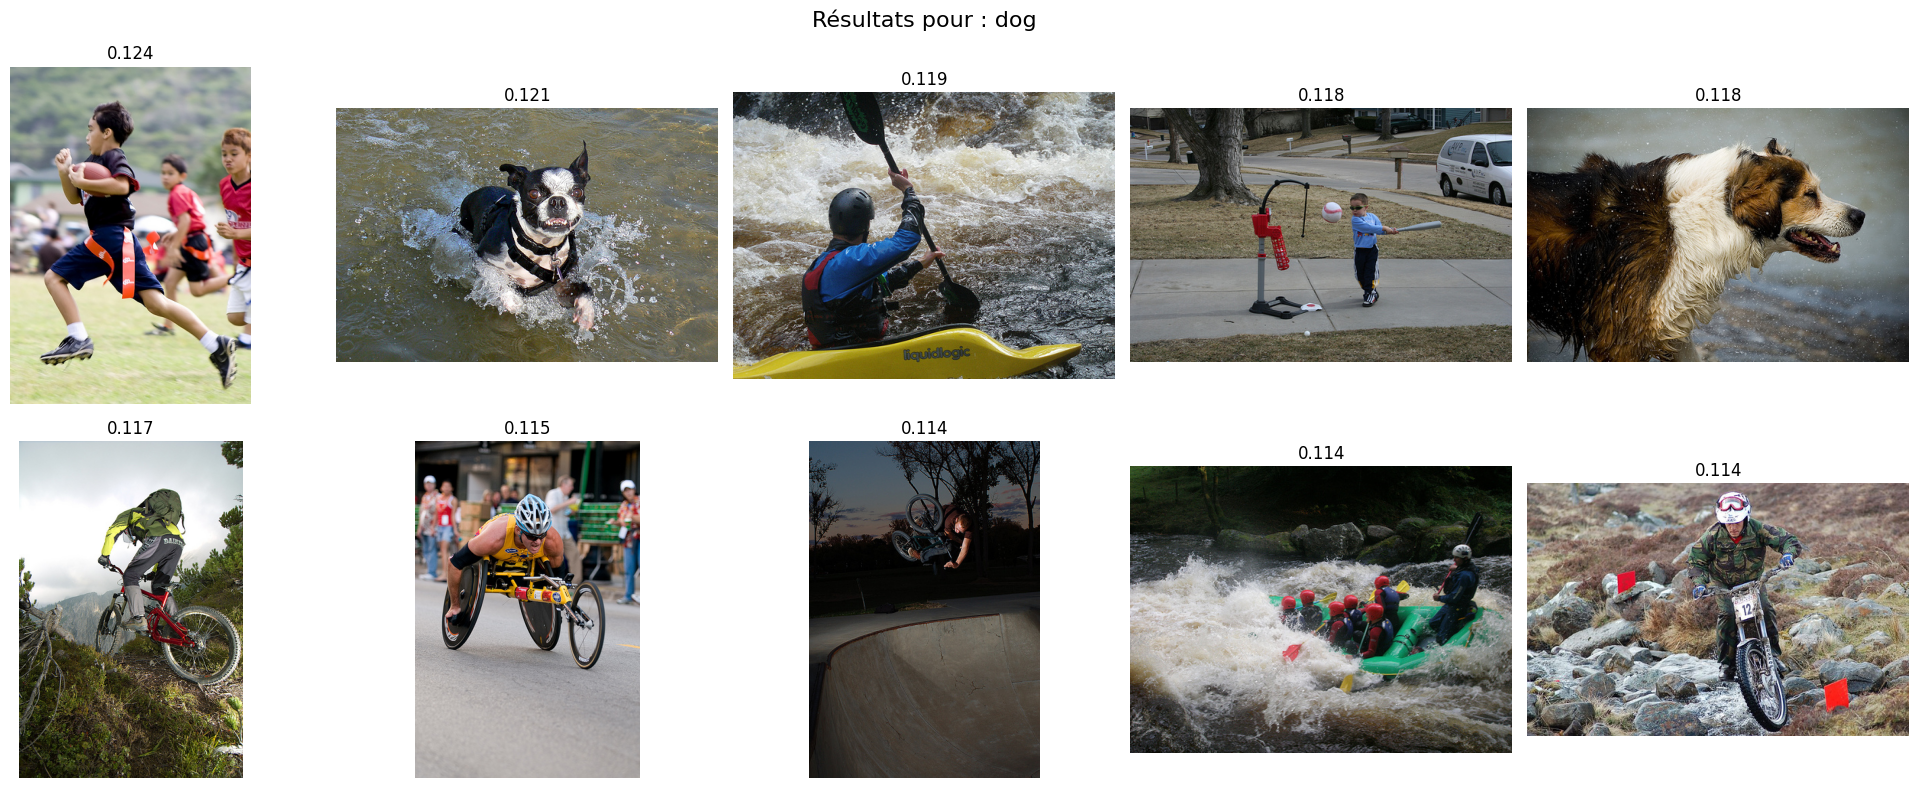

In [ ]:
query = "dog"
top_images = search_images_by_text(query, top_k=10)

show_topk_images(top_images, title=f"Résultats pour : {query}")
